# 1D Post-stack inversion with proximal solvers

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from matplotlib.colors import LinearSegmentedColormap

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal.proximal import VStack as VStackprox
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import *

In [2]:
os.environ['NUMBA_NUM_THREADS']

'4'

In [3]:
def RRE(x, xinv):
    return np.linalg.norm(x-xinv) / np.linalg.norm(x)

In [4]:
def PSNR(x, xinv):
    return 10 * np.log10(len(xinv) * np.max(xinv) / np.linalg.norm(x-xinv))

We consider the following problem

$$
\mathbf{x} = arg min_\mathbf{x} \frac{\sigma}{2} ||\mathbf{W}\mathbf{D}\mathbf{x} - \mathbf{y} ||_2^2 + ||\mathbf{D} \mathbf{x}||_1
$$

### True proximal of convolution operator

In [20]:
nt = 101
dt = 0.004
t = np.arange(nt)*dt
wav, th, wavc = ricker(t[:11], f0=20)

x = 1800 * np.ones(nt)
x[nt//4:nt//2] = 2000
x[nt//2:2*nt//3] = 1700
x = np.log(x)

# Add gradient at the end 
#istart = nt-35
#iend = nt-20
#xgrad = np.arange(iend - istart) * (x[0] - x[istart-1]) / (iend - istart) + x[istart-1]
#x[istart:iend] = xgrad
#x[iend:] = x[0]

In [21]:
# Background model
x0 = filtfilt(np.ones(30)/30, 1, x)

# Data
Lop = PoststackLinearModelling(wav, nt)
y = Lop * x
y = y + np.random.normal(0, 0e-3, x.shape)

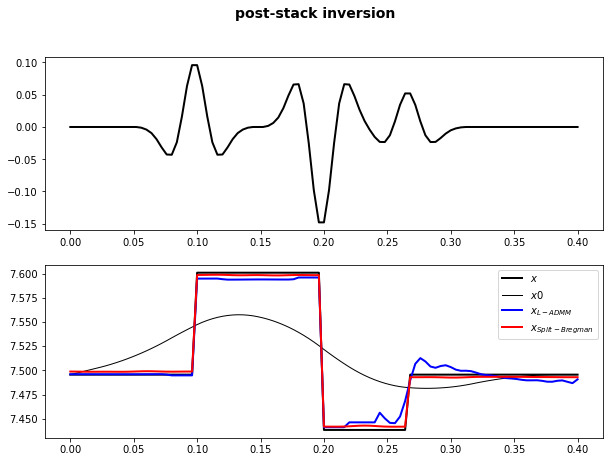

In [22]:
sigma=0.01
l1 = VStackprox([L1(sigma=sigma), L2(sigma=sigma)], [60, nt-60])#L1(sigma=sigma)
l2 = L2(Op=Lop, b=y, niter=10)
Dop = FirstDerivative(nt, edge=True, kind='forward')

# Split-Bregman
mu = 1.3
lamda = 0.15
niter = 100
niterinner = 3
xsb = SplitBregman(Lop, [Dop], y, niter, niterinner, mu=mu, epsRL1s=[lamda], x0=x0,
                   tol=1e-4, tau=1, **dict(iter_lim=30, damp=1e-3))[0]

# L-ADMM
#tau = 1. / np.real((Lop.H*Lop).eigs(neigs=1, which='LM')[0]) # optimal tau=1/maxeig(Lop^H Lop)
#mu = 0.99 * tau / np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0]) # optimal mu=tau/maxeig(Dop^H Dop)
L = 8 #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)
xladmm, zladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=x0, niter=500)

fig, axs = plt.subplots(2, 1, figsize=(10, 7))
fig.suptitle('post-stack inversion', fontsize=14, fontweight='bold')
axs[0].plot(t, y, 'k', lw=2, label=r'$y$')
axs[1].plot(t, x, 'k', lw=2, label=r'$x$')
axs[1].plot(t, x0, 'k', lw=1, label=r'$x0$')
axs[1].plot(t, xladmm, 'b', lw=2, label=r'$x_{L-ADMM}$')
axs[1].plot(t, xsb, 'r', lw=2, label=r'$x_{Split-Bregman}$')
axs[1].legend();

And we use now Bregman iterations with LinearizedADMM

sigma = 0.05
l1 = L1(sigma=sigma)
l2 = L2(Op=Lop, b=y, alpha=sigma, qgrad=False, niter=20, warm=True)
Dop = FirstDerivative(nt, edge=True, kind='forward')

L = np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

xb = BregmanOld(l2, l1, x0, LinearizedADMM, A=Dop, niterouter=10, show=True,
                **dict(tau=tau, mu=mu, niter=400))

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
fig.suptitle('post-stack inversion', fontsize=14, fontweight='bold')
ax.plot(t, x, 'k', lw=2, label=r'$x$')
ax.plot(t, x0, 'k', lw=1, label=r'$x0$')
ax.plot(t, xladmm, 'b', lw=2, label=r'$x_{L-ADMM}$')
ax.plot(t, xb, 'r', lw=2, label=r'$x_{Bregman/L-ADMM}$')
ax.legend();

Bregman
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.FirstDerivative.FirstDerivative'>
Inner Solver: <function LinearizedADMM at 0x1a20361730>
alpha = 5.000000e-02	tolf = 1.000000e-10	tolx = 1.000000e-10
niter = 10

   Itn       x[0]          f           g       J = f + g
     1   7.50200e+00   7.573e-04   1.202e-02   1.277e-02
     2   7.49609e+00   8.639e-07   1.350e-02   1.350e-02
     3   7.49589e+00   4.446e-07   1.350e-02   1.350e-02
     4   7.49583e+00   3.161e-07   1.350e-02   1.350e-02
     5   7.49579e+00   2.548e-07   1.350e-02   1.350e-02
     6   7.49576e+00   2.189e-07   1.350e-02   1.350e-02
     7   7.49573e+00   1.950e-07   1.350e-02   1.350e-02
     8   7.49570e+00   1.776e-07   1.350e-02   1.350e-02
     9   7.49568e+00   1.642e-07   1.350e-02   1.350e-02
    10   7.49565e+00   1

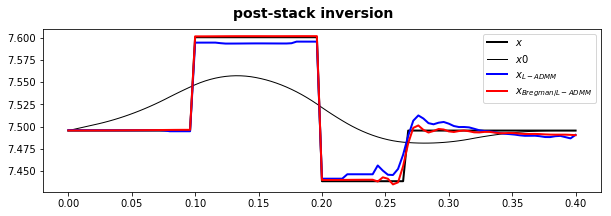

In [23]:
sigma = 0.05
l1 = VStackprox([L1(), L2()], [60, nt-60]) #L1()
l2 = L2(Op=Lop, b=y, niter=20, warm=True)
Dop = FirstDerivative(nt, edge=True, kind='forward')

# approach with norms of 2 operators (CHECK!)
#tau = 1. / np.real((Lop.H*Lop).eigs(neigs=1, which='LM')[0]) # optimal tau=1/maxeig(Lop^H Lop)
#mu = 0.99 * tau / np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0]) # optimal mu=tau/maxeig(Dop^H Dop)

# most common approach
L = np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

xb = Bregman(l2, l1, x0, LinearizedADMM, A=Dop, alpha=sigma, 
             niterouter=10, show=True, **dict(tau=tau, mu=mu, niter=400))

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
fig.suptitle('post-stack inversion', fontsize=14, fontweight='bold')
ax.plot(t, x, 'k', lw=2, label=r'$x$')
ax.plot(t, x0, 'k', lw=1, label=r'$x0$')
ax.plot(t, xladmm, 'b', lw=2, label=r'$x_{L-ADMM}$')
ax.plot(t, xb, 'r', lw=2, label=r'$x_{Bregman/L-ADMM}$')
ax.legend();

And PrimalDual solver

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.FirstDerivative.FirstDerivative'>
Additional vector (z): None
tau = 3.358757e-01	mu = 3.535534e-01
theta = 1.00		niter = 200

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   7.49553e+00   1.370e-02   2.890e-03   0.000e+00       1.659e-02
     2   7.49518e+00   5.442e-03   3.668e-03   0.000e+00       9.109e-03
     3   7.49471e+00   3.333e-03   3.860e-03   0.000e+00       7.193e-03
     4   7.49426e+00   2.504e-03   3.837e-03   0.000e+00       6.342e-03
     5   7.49398e+00   2.078e-03   3.926e-03   0.000e+00       6.004e-03
     6   7.49393e+00   1.816e-03   4.082e-03   0.000e+00       5.898e-03
     7   7.49415e+00   1.636e-03   4.155e-03   0.000e+00       5.791e-03
     8   7.4

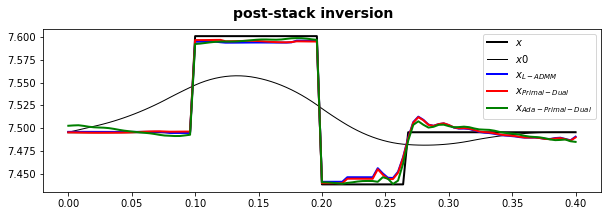

In [32]:
sigma=0.01
l1 = VStackprox([L1(sigma=sigma), L2(sigma=sigma)], [60, nt-60]) #L1(sigma=sigma)
l2 = L2(Op=Lop, b=y, niter=10)
Dop = FirstDerivative(nt, edge=True, kind='forward')

# most common approach
L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
#tau = 1.
#mu = 0.99 / (tau * L)
tau = 0.95 / np.sqrt(L)
mu = 0.95 / (tau * L)

xpd = PrimalDual(l2, l1, Dop, x0, tau=tau, mu=mu, niter=200, show=True)

xpd_ada, steps = AdaptivePrimalDual(l2, l1, Dop, x0, tau=tau, mu=mu, s=0.1,
                                    niter=80, show=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
fig.suptitle('post-stack inversion', fontsize=14, fontweight='bold')
ax.plot(t, x, 'k', lw=2, label=r'$x$')
ax.plot(t, x0, 'k', lw=1, label=r'$x0$')
ax.plot(t, xladmm, 'b', lw=2, label=r'$x_{L-ADMM}$')
ax.plot(t, xpd, 'r', lw=2, label=r'$x_{Primal-Dual}$')
ax.plot(t, xpd_ada, 'g', lw=2, label=r'$x_{Ada-Primal-Dual}$')
ax.legend();

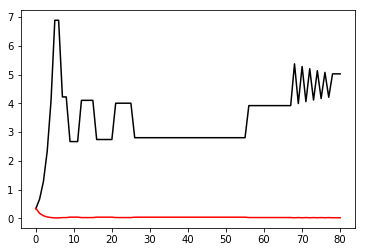

In [34]:
plt.figure()
plt.plot(steps[0], 'k')
plt.plot(steps[1], 'r');

We can also choose the niter in L2 to be adaptive, start with fewer and then increase

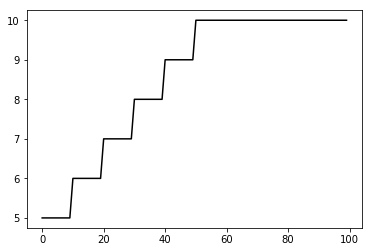

In [11]:
def niter(count, niter0, k, nitermax):
    niter = min(int(niter0 + k * count), nitermax)
    return niter

plt.figure()
plt.plot(np.array([niter(i, 5, 0.1, 10) for i in np.arange(100)]), 'k');

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.FirstDerivative.FirstDerivative'>
Additional vector (z): None
tau = 1.000000e+00	mu = 1.237500e-01
theta = 1.00		niter = 200

   Itn       x[0]          f           g       J = f + g
     1   7.48269e+00   2.658e-02   8.094e-03   3.467e-02
     2   7.48473e+00   3.366e-03   5.428e-03   8.794e-03
     3   7.48656e+00   1.386e-03   4.739e-03   6.124e-03
     4   7.48751e+00   1.159e-03   4.433e-03   5.592e-03
     5   7.48795e+00   1.108e-03   4.148e-03   5.256e-03
     6   7.48838e+00   1.037e-03   4.109e-03   5.146e-03
     7   7.48984e+00   9.195e-04   4.278e-03   5.198e-03
     8   7.49213e+00   8.467e-04   4.356e-03   5.202e-03
     9   7.49474e+00   7.702e-04   4.311e-03   5.081e-03
    10   7.49738e+00   7.116e

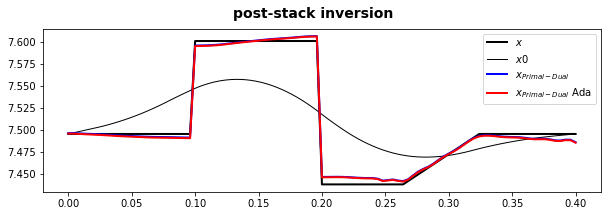

In [12]:
sigma=0.01
l1 = VStackprox([L1(sigma=sigma), L2(sigma=sigma)], [60, nt-60]) #L1(sigma=sigma)
l2 = L2(Op=Lop, b=y, niter=lambda x: niter(x, 5, 0.1, 10))
Dop = FirstDerivative(nt, edge=True, kind='forward')

# most common approach
L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

xpd_ada = PrimalDual(l2, l1, Dop, x0, tau=tau, mu=mu, niter=200, show=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
fig.suptitle('post-stack inversion', fontsize=14, fontweight='bold')
ax.plot(t, x, 'k', lw=2, label=r'$x$')
ax.plot(t, x0, 'k', lw=1, label=r'$x0$')
ax.plot(t, xpd, 'b', lw=2, label=r'$x_{Primal-Dual}$')
ax.plot(t, xpd_ada, 'r', lw=2, label=r'$x_{Primal-Dual}$ Ada')
ax.legend();

### Approximated proximal of convolution operator

Now we use the fact that the modelling operator is a convolution to speed up the solution of the proximal operator.

First we ensure that we can rewrite our modelling operator as pure convolution and use that filter as input to our fast L2Convolve

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2Convolve'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.FirstDerivative.FirstDerivative'>
tau = 1.000000e+00	mu = 2.475599e-01	niter = 1000

   Itn       x[0]          f           g       J = f + g
     1   7.49686e+00   1.775e-02   2.479e-03   2.023e-02
     2   7.49889e+00   7.688e-03   3.123e-03   1.081e-02
     3   7.50088e+00   4.217e-03   3.244e-03   7.461e-03
     4   7.50252e+00   2.815e-03   3.537e-03   6.352e-03
     5   7.50373e+00   2.171e-03   3.732e-03   5.904e-03
     6   7.50453e+00   1.828e-03   3.783e-03   5.611e-03
     7   7.50498e+00   1.630e-03   3.785e-03   5.416e-03
     8   7.50517e+00   1.510e-03   3.722e-03   5.232e-03
     9   7.50521e+00   1.429e-03   3.667e-03   5.097e-03
    10   7.50520e+00   1.368e-03   3.670e-03   5.038e-03
   101   7.49265e+00   3.135e

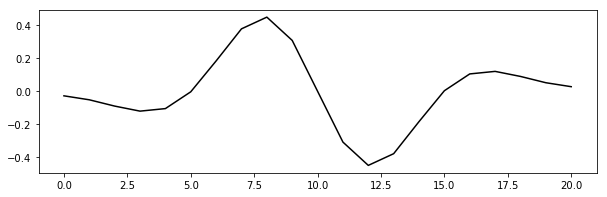

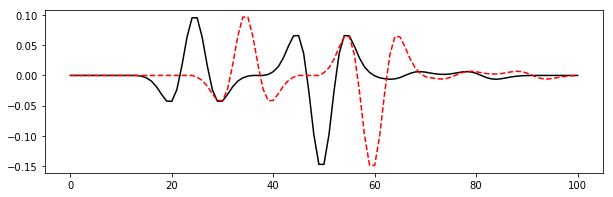

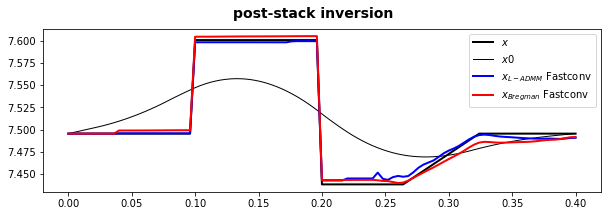

In [14]:
derivative = np.array([0.5, 0, -0.5])
h = np.convolve(derivative, wav, mode='same')

plt.figure(figsize=(10, 3))
plt.plot(h, 'k')

# data
nfft = nt
y1 = np.fft.ifft(np.fft.fft(x, nfft) * np.fft.fft(h, nfft))

plt.figure(figsize=(10, 3))
plt.plot(y, 'k')
plt.plot(y1, '--r')

# LinearizedADMM inversion
sigma=0.01
l1 = VStackprox([L1(sigma=sigma), L2(sigma=sigma)], [50, nt-50]) #L1(sigma=sigma)
l2 = L2Convolve(h=h, b=y, nfft=nt)
Dop = FirstDerivative(nt, edge=True, kind='forward')

L = np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)
xladmm, zladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=x0, niter=1000, show=True)

# Bregman inversion
sigma=0.1
l1 = VStackprox([L1(), L2()], [50, nt-50]) #L1()
xb = Bregman(l2, l1, x0, LinearizedADMM, A=Dop, niterouter=5, alpha=sigma, 
             show=True, **dict(tau=tau, mu=mu, niter=400))

# recenter signal 
xladmm = np.pad(xladmm[:-wavc], (wavc, 0), constant_values=x0[0])
xb = np.pad(xb[:-wavc], (wavc, 0), constant_values=x0[0])

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
fig.suptitle('post-stack inversion', fontsize=14, fontweight='bold')
ax.plot(t, x, 'k', lw=2, label=r'$x$')
ax.plot(t, x0, 'k', lw=1, label=r'$x0$')
ax.plot(t, xladmm, 'b', lw=2, label=r'$x_{L-ADMM}$ Fastconv')
ax.plot(t, xb, 'r', lw=2, label=r'$x_{Bregman}$ Fastconv')
ax.legend();

This seems to work under the following conditions:

1. we need to assume that our filter has a certain phase (not centered to zero)... and then recenter things ourselves
2. the model at the top and base should have same AI, otherwise the modelling artificially creates a discontinuity and a new event in the data... if not the case, we need pad the base with an artificial gradient
3. we need to separate the regularization between the model part and the gradient

Let's give a quick try with 2d data

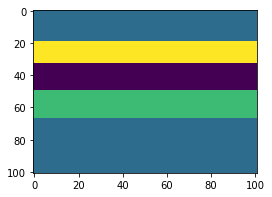

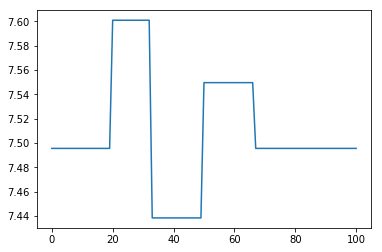

In [41]:
nt0, nx = 101, 101
dt0 = 0.004
t0 = np.arange(nt0)*dt0

ai = 1800 * np.ones(nt0)
ai[nt0//5:nt0//3] = 2000
ai[nt0//3:nt0//2] = 1700
#ai[nt0//2:2*nt0//3] = 1900
ai[nt0//2:2*nt0//3] = 1900

ai2d = np.outer(ai, np.ones(nx))
m = np.log(ai2d)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.imshow(m)
ax.axis('tight')

plt.figure()
plt.plot(m[:, nx//2]);

Let's imagine our model stops at the 80th sample. What we have here is a discontinuity with the 0th sample which will create an fake event when modelling with one-step convolution.

But we can create an artifical gradient in the model to avoid having any change between the top and base of the model

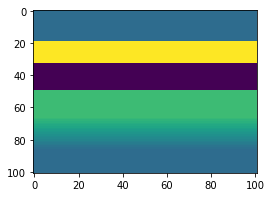

In [43]:
istart = nt0-35 
iend = nt0-15

mgrad = np.arange(iend - istart) * (ai[0] - ai[istart-1]) / (iend - istart) + ai[istart-1]
mgrad = np.outer(mgrad, np.ones(nx))
mgrad = np.log(mgrad)
m[istart:iend] = mgrad
m[iend:] = m[0]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.imshow(m)
ax.axis('tight');

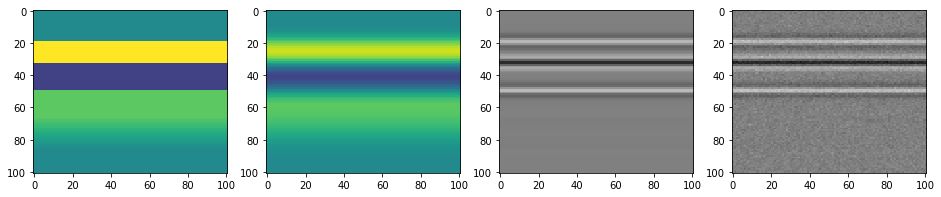

In [44]:
# smooth model
nsmooth = 10
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)

# operator
wav, th, wavc = ricker(t[:11], f0=30)
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

# data
d = Lop * m.ravel()

# noise
sigman = 5e-3
dn = d + np.random.normal(0, sigman, d.shape)

d = d.reshape(nt0, nx)
dn = dn.reshape(nt0, nx)

fig, axs = plt.subplots(1, 4, figsize=(16, 3))
axs[0].imshow(m, vmin=7.4, vmax=7.6)
axs[0].axis('tight')
axs[1].imshow(mback, vmin=7.4, vmax=7.6)
axs[1].axis('tight')
axs[2].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight')
axs[3].imshow(dn, cmap='gray', vmin=-0.1, vmax=0.1)
axs[3].axis('tight');

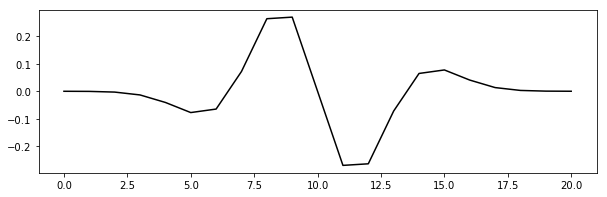

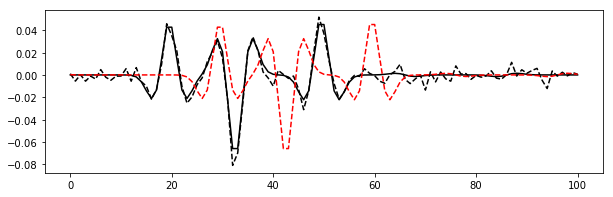

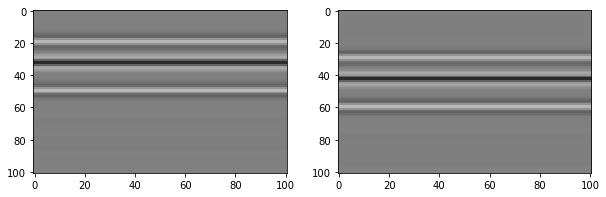

In [45]:
derivative = np.array([0.5, 0, -0.5])
h = np.convolve(derivative, wav / 2, mode='same')

plt.figure(figsize=(10, 3))
plt.plot(h, 'k')

# data
nfft = nt0
d1 = np.real(np.fft.ifft(np.fft.fft(m, nfft, axis=0) * \
                         np.fft.fft(h, nfft)[:, np.newaxis], axis=0))
               
plt.figure(figsize=(10, 3))
plt.plot(d[:, 0], 'k')
plt.plot(dn[:, 0], '--k')
plt.plot(d1[:, 0], '--r')

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1)
axs[0].axis('tight')
axs[1].imshow(d1, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2Convolve'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
tau = 1.000000e+00	mu = 1.237500e-01	niter = 1000

   Itn       x[0]          f           g       J = f + g
     1   7.49517e+00   1.230e+00   3.487e-01   1.579e+00
     2   7.49489e+00   1.032e+00   3.708e-01   1.403e+00
     3   7.49468e+00   8.849e-01   3.936e-01   1.279e+00
     4   7.49456e+00   7.799e-01   4.185e-01   1.198e+00
     5   7.49456e+00   7.028e-01   4.397e-01   1.143e+00
     6   7.49470e+00   6.428e-01   4.560e-01   1.099e+00
     7   7.49499e+00   5.937e-01   4.687e-01   1.062e+00
     8   7.49543e+00   5.526e-01   4.768e-01   1.029e+00
     9   7.49600e+00   5.177e-01   4.810e-01   9.988e-01
    10   7.49667e+00   4.879e-01   4.849e-01   9.728e-01
   101   7.49291e+00   2.178e-01   4.912e-01   

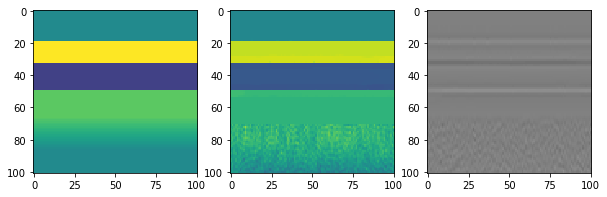

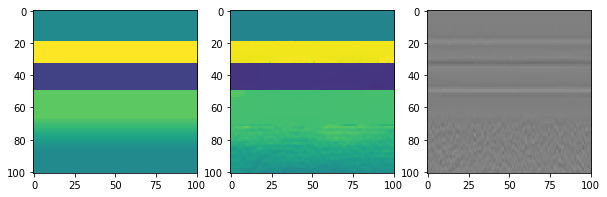

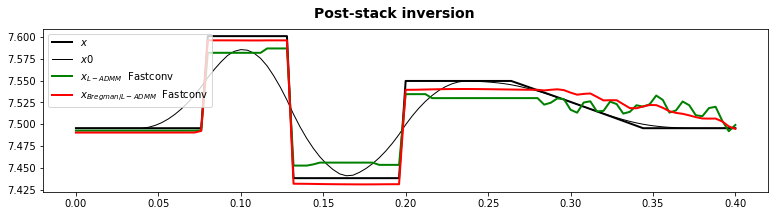

In [51]:
# L-ADMM (Blockiness-promoting inversion with isotropic TV)
sigma=.01
#l1 = L21(ndim=2, sigma=sigma)
l1 = VStackprox([L21(ndim=2, sigma=sigma), L2(sigma=sigma), L2(sigma=sigma)], 
                restr=[Restriction(nt0*nx*2, np.hstack((np.arange(60*nx), np.arange(nt0*nx, nt0*nx + 60*nx)))),
                       Restriction(nt0*nx*2, np.arange(60*nx, nt0*nx)),
                       Restriction(nt0*nx*2, np.arange(nt0*nx + 60*nx, 2*nt0*nx))]) 
l2 = L2Convolve(h=h, b=dn, nfft=nt0, dims=(nt0, nx), dir=0)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)
mconv = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=mback.ravel(), niter=1000, show=True)[0]
mconv = np.real(mconv.reshape(nt0, nx))

# Bregman inversion
sigma=0.05
#l1 = L21(ndim=2)
l1 = VStackprox([L21(ndim=2), L2(), L2(sigma=100)], 
                restr=[Restriction(nt0*nx*2, np.hstack((np.arange(60*nx), np.arange(nt0*nx, nt0*nx + 60*nx)))),
                       Restriction(nt0*nx*2, np.arange(60*nx, nt0*nx)),
                       Restriction(nt0*nx*2, np.arange(nt0*nx + 60*nx, 2*nt0*nx))]) 
mconvb = Bregman(l2, l1, mback.ravel(), LinearizedADMM, A=Dop, niterouter=5, alpha=sigma, 
                 show=True, **dict(tau=tau, mu=mu, niter=400))
mconvb = np.real(mconvb.reshape(nt0, nx))

# recenter model
mconv = np.vstack([mconv[0] * np.ones((wavc, 1)), mconv[:-wavc]])
mconvb = np.vstack([mconvb[0] * np.ones((wavc, 1)), mconvb[:-wavc]])

dinv = Lop * mconv.ravel()
dinv = dinv.reshape(nt0, nx)

dinvb = Lop * mconvb.ravel()
dinvb = dinv.reshape(nt0, nx)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(m, vmin=7.4, vmax=7.6)
axs[0].axis('tight')
axs[1].imshow(mconv, vmin=7.4, vmax=7.6)
axs[1].axis('tight')
axs[2].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight')

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].imshow(m, vmin=7.4, vmax=7.6)
axs[0].axis('tight')
axs[1].imshow(mconvb, vmin=7.4, vmax=7.6)
axs[1].axis('tight')
axs[2].imshow(d-dinvb, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight')

fig, ax = plt.subplots(1, 1, figsize=(13, 3))
fig.suptitle('Post-stack inversion', fontsize=14, fontweight='bold')
ax.plot(t0, m[:, nx//2], 'k', lw=2, label=r'$x$')
ax.plot(t0, mback[:, nx//2], 'k', lw=1, label=r'$x0$')
ax.plot(t0, mconv[:, nx//2], 'g', lw=2, label=r'$x_{L-ADMM}$  Fastconv')
ax.plot(t0, mconvb[:, nx//2], 'r', lw=2, label=r'$x_{Bregman/L-ADMM}$  Fastconv')
ax.legend();

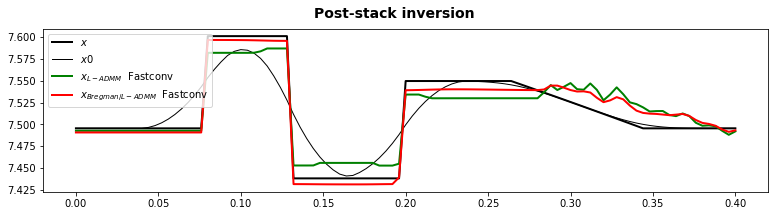

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(13, 3))
fig.suptitle('Post-stack inversion', fontsize=14, fontweight='bold')
ax.plot(t0, m[:, nx//4], 'k', lw=2, label=r'$x$')
ax.plot(t0, mback[:, nx//4], 'k', lw=1, label=r'$x0$')
ax.plot(t0, mconv[:, nx//4], 'g', lw=2, label=r'$x_{L-ADMM}$  Fastconv')
ax.plot(t0, mconvb[:, nx//4], 'r', lw=2, label=r'$x_{Bregman/L-ADMM}$  Fastconv')
ax.legend();